# **Predicting Vehicles With pytorch**

## **Import Libraries**

In [75]:

import os
import torch
import numpy as np
from typing import List, Optional, TypeVar
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.optim import Optimizer
from torch.functional import F
from torch.types import Device
from torch import nn
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder

In [61]:
# Set the seed for reproducibly
torch.manual_seed(42)
np.random.seed(42)

BATCH_SIZE = 16
EPOCH = 5

## **Load The Data**

In [62]:
try:
    import google.colab
    if not os.path.exists("vehicles"):
        os.system('git clone "https://github.com/denis-spe/vehicles"')

    # Directory of dataset
    data_dir = "vehicles/vehicles"
except:
    # Directory of dataset
    data_dir = 'vehicles/vehicles'

In [63]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

In [64]:
# Create a ImageFolder object: dataset
dataset = ImageFolder(
    data_dir,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((300, 300), antialias=True)
    ]),
    target_transform=lambda x: torch.tensor(x)
    )
dataset

Dataset ImageFolder
    Number of datapoints: 196
    Root location: vehicles/vehicles
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=(300, 300), interpolation=bilinear, max_size=None, antialias=True)
           )
Target transform: <function <lambda> at 0x7bd50027f010>

In [65]:
# classes
classes = dataset.classes
classes

['bus', 'car', 'motorbike', 'truck']

In [66]:
# Set the seed for reproducibly
generator = torch.Generator(device=device).manual_seed(42)

# Number of images
n_imgs = len(dataset)

# Train and validation sample size
train_size = int(n_imgs * 0.75)
val_size = n_imgs - train_size

# Split the data into train and validation data
train_dataset, val_dataset = random_split(dataset, lengths=[train_size, val_size], generator=generator)

print("Number of train samples: %s\nNumber of val samples: %s" % (len(train_dataset), len(val_dataset)))

Number of train samples: 147
Number of val samples: 49


In [67]:
# Construct a DataLoader objects
train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
    )
val_dataloader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    )

In [68]:

# Get one of the image from the train data
img, label = next(iter(train_dataloader.dataset))
img.shape

torch.Size([3, 300, 300])

In [69]:
label

tensor(1)

## **Visualise The Images**

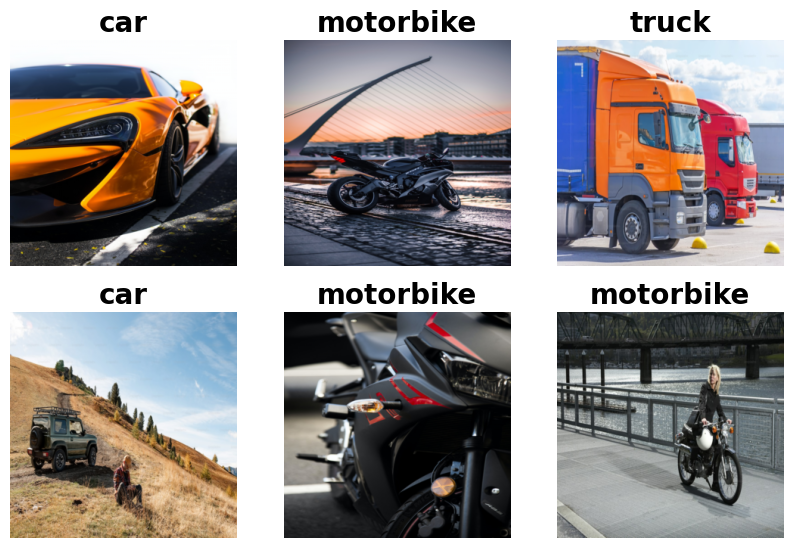

In [70]:
NCOL = 3
NROW = 3

# Create a figure
fig = plt.figure(figsize=(10, 10))

for i in range(1, NCOL + NROW + 1):
    # Initialize the image and label
    img, label = train_dataloader.dataset[i]

    # Add a subplot
    fig.add_subplot(NCOL, NROW, i)

    # plot the image
    plt.imshow(img.permute(1, 2, 0))
    plt.axis('off')
    plt.title(classes[label], weight="bold", size=20)

## **Model Building**

In [76]:
class Model(nn.Module):
    def __init__(self, layers: List) -> None:
        super(Model, self).__init__()
        self.stacked_layers = nn.Sequential(*layers)
        self.optimizer: Optional[Optimizer] = None
        self.loss = None
        self.device: Device = None

    def forward(self, x):
       return self.stacked_layers(x)

    def compile(self, optimizer: Optimizer, loss) -> None:
       self.optimizer = optimizer
       self.loss = loss

    def training_data(self, dataloader: DataLoader):
       # Indicate model to training
       self.train()

       if not self.optimizer or not self.loss:
           raise AttributeError('Compile the model with `model.compile` before fitting the model')

       # Loop over the dataset
       for image, label in dataloader:
           # Make predicts
           pred = self(image)
           print(pred.argmax(1))

           # Encode the label to the one hot
           one_hot = F.one_hot(label, num_classes=4)

           # Compute the loss
           loss = self.loss(pred, label)

           print(loss)
        #    break

In [72]:
model = Model([
           nn.Flatten(),
           nn.Linear(
             3 * 300 * 300,
             out_features=1029),
           nn.Linear(
             1029,
             out_features=4),
           nn.Softmax(dim=0)
        ])

model.compile(
     optimizer=torch.optim.Adam(
        model.parameters()
        ),
     loss=nn.CrossEntropyLoss()
   )

In [73]:
model.training_data(train_dataloader)

tensor([1, 3, 1, 2, 2, 3, 3, 1, 3, 1, 2, 1, 2, 0, 1, 2])
tensor(1.3858, grad_fn=<NllLossBackward0>)
tensor([1, 1, 1, 2, 3, 0, 3, 3, 1, 0, 2, 3, 2, 0, 3, 2])
tensor(1.3866, grad_fn=<NllLossBackward0>)
tensor([0, 0, 2, 0, 3, 2, 3, 3, 2, 2, 1, 1, 0, 0, 1, 2])
tensor(1.3851, grad_fn=<NllLossBackward0>)
tensor([0, 1, 2, 0, 0, 3, 1, 0, 3, 3, 3, 1, 0, 1, 1, 2])
tensor(1.3853, grad_fn=<NllLossBackward0>)
tensor([0, 3, 1, 1, 3, 0, 1, 1, 2, 2, 0, 3, 3, 3, 1, 1])
tensor(1.3877, grad_fn=<NllLossBackward0>)
tensor([2, 3, 0, 0, 2, 1, 1, 1, 2, 2, 3, 0, 3, 1, 2, 3])
tensor(1.3864, grad_fn=<NllLossBackward0>)
tensor([1, 1, 1, 2, 0, 1, 0, 0, 3, 3, 2, 1, 2, 1, 3, 2])
tensor(1.3852, grad_fn=<NllLossBackward0>)
tensor([2, 0, 3, 3, 1, 1, 2, 1, 1, 2, 3, 1, 0, 2, 3, 3])
tensor(1.3871, grad_fn=<NllLossBackward0>)
tensor([2, 1, 3, 1, 1, 0, 1, 3, 0, 2, 3, 3, 1, 2, 1, 3])
tensor(1.3854, grad_fn=<NllLossBackward0>)
tensor([2, 3, 1])
tensor(1.3645, grad_fn=<NllLossBackward0>)


In [74]:
img, label = next(iter(train_dataloader))
model(img)

tensor([[0.0532, 0.0544, 0.0556, 0.0684],
        [0.0575, 0.0638, 0.0651, 0.0616],
        [0.0548, 0.0641, 0.0718, 0.0626],
        [0.0766, 0.0729, 0.0604, 0.0634],
        [0.0598, 0.0555, 0.0654, 0.0588],
        [0.0657, 0.0610, 0.0641, 0.0700],
        [0.0671, 0.0812, 0.0595, 0.0547],
        [0.0546, 0.0575, 0.0576, 0.0603],
        [0.0641, 0.0746, 0.0634, 0.0621],
        [0.0640, 0.0503, 0.0540, 0.0605],
        [0.0656, 0.0552, 0.0612, 0.0608],
        [0.0658, 0.0608, 0.0614, 0.0615],
        [0.0604, 0.0510, 0.0691, 0.0642],
        [0.0578, 0.0589, 0.0642, 0.0649],
        [0.0668, 0.0675, 0.0634, 0.0632],
        [0.0663, 0.0714, 0.0637, 0.0631]], grad_fn=<SoftmaxBackward0>)